<a href="https://colab.research.google.com/github/vcipi/plant-disease-classification-ML-Project/blob/main/ML_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install split-folders
!pip install pyyaml h5py
!pip install transformers
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.0 MB/s 
     |████████████████████████████████| 120 kB 61.8 MB/s 
     |████████████████████████████████| 6.6 MB 52.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [4]:
import numpy as np
import pandas as pd
import pickle
import cv2
import glob
import os, os.path
import matplotlib.pyplot as plt
import seaborn as sn
import splitfolders
import tensorflow as tf
import tensorflow_addons as tfa
import sklearn.metrics as metrics

from os import listdir
from typing import Tuple, List
from urllib.request import urlopen,urlretrieve
from PIL import Image
from numpy.ma.core import append
from pathlib import Path
%matplotlib inline

from tqdm import tqdm, tqdm_notebook

from tensorflow import keras
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers

from skimage.io import imread
from skimage.measure import block_reduce

from keras import backend as K
from keras import optimizers
from keras import applications
from keras.utils import np_utils
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, MaxPooling2D, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions

from keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint

from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn.datasets import load_files

from google.colab import files, drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# function from Mr Perakis notes
def fetch_files():
    # fetch files from user's github page
    if not os.path.exists('plant_disease-master'):
        !curl -L -O https://github.com/spMohanty/PlantVillage-Dataset/archive/master.zip
        !unzip -q master.zip
        !rm master.zip
    
        print('Done')

In [10]:
def training_plots (model,history):
  fig, axs = plt.subplots(2,  figsize=(16,8))
  
  axs[0].plot(history.history['loss'], label = 'train')
  axs[0].plot(history.history['val_loss'], label = 'val')

  axs[1].plot(history.history['accuracy'], label = 'train')
  axs[1].plot(history.history['val_accuracy'], label = 'val')

  axs[0].set_xlabel('Epoch')
  axs[1].set_xlabel('Epoch')
  
  axs[0].set_ylabel('Loss')
  axs[1].set_ylabel('Accuracy')

  legend_1 = axs[0].legend(loc='lower left', borderaxespad=3)
  legend_1.get_frame().set_edgecolor('b')
  legend_1.get_frame().set_linewidth(1.0)
  legend_1.get_frame().set_facecolor('w')

  legend_2 = axs[1].legend(loc='upper left', borderaxespad=3)
  legend_2.get_frame().set_edgecolor('b')
  legend_2.get_frame().set_linewidth(1.0)
  legend_2.get_frame().set_facecolor('w')
  fig.suptitle('Diagnostic plots')

In [11]:
# function from Mr Perakis notes
def print_confusion_matrix(y_true,
                           y_pred,
                           class_names: List[str],
                           figsize: Tuple[int, int] = (20, 16),
                           fontsize: int = 14) -> pd.DataFrame:
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heat-map.

    :param class_names:  An ordered list of class names
    :param figsize: A 2-long tuple, the first value determining the horizontal size of the outputted
                    figure, the second determining the vertical size. Defaults to (10,7).
    :param fontsize: Font size for axes labels. Defaults to 14.
    :return: The confusion matrix as a dataset
    """
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

    df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

    fig = plt.figure(figsize=figsize)

    try:
        heatmap = sn.heatmap(df_cm, annot=True, fmt="d")

    except ValueError:

        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                                 rotation=0,
                                 ha='right',
                                 fontsize=fontsize)

    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                                 rotation=90,
                                 ha='right',
                                 fontsize=fontsize)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return df_cm

In [12]:
def plotImage(img_arr, label):

  for im, l in zip(img_arr, label):
    plt.figure(figsize=(5,5))
    plt.imshow(im)
    plt.show()

In [13]:
# from Mr. Perakis notes
def examples_to_dataset(img_paths: List[Path],
                        labels: List[int],
                        block_size: int = 2,
                        as_gray: bool = True):
    """
    This function, given the img_paths loads the images from disk.
    Also, it reduces the images size by under-sampling the pixels


    block_size:
    1: same size.
    2: undersample by 2

    :param img_paths: A list of Paths that define the locations of our images
    :param labels: The labels of our images
    :param block_size: Int. 1 stay unchanged. 2 subsample by 2 etc
    :param as_gray:
    :return:
    """
    assert len(img_paths) == len(labels)

    X = []
    y = []

    for path, label in tqdm(zip(img_paths, labels)):
        # reads the image from the filepath
        img = imread(str(path),
                     as_gray=as_gray)

        # reduces the image size by x times by taking the mean of the pixels.
        img = block_reduce(img,
                           block_size=(block_size,
                                       block_size,
                                       1),
                           func=np.mean)

        X.append(img)

        y.append(label)

    return X, y

In [14]:
# fetching files
fetch_files()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2387M    0 2387M    0     0  16.0M      0 --:--:--  0:02:29 --:--:-- 18.5M
Done


In [15]:
input_folder = '/content/PlantVillage-Dataset-master/raw/color'  

output_folder= '/content/PlantVillage-Dataset-master/raw/split'

splitfolders.ratio(input_folder, output= output_folder, seed=1337, ratio = (0.8, 0.1, 0.1))

Copying files: 54305 files [00:10, 4951.91 files/s]


In [ ]:
# check images' dimensions
paths = glob.glob('/content/PlantVillage-Dataset-master/raw/split/*/*/*',  recursive = True)
image_height = []
image_width = []
image_channels = []
for path in paths:
  img = image.load_img(path)
  x = image.img_to_array(img)
  image_height.append(x.shape[0])
  image_width.append(x.shape[1])
  image_channels.append(x.shape[2])

from collections import Counter
print(f" Images' height are: {Counter(image_height).keys()}") 
print(f" Images' width are: {Counter(image_width).keys()}") 
print(f" Images' channles are: {Counter(image_channels).keys()}")

So all are images are of shape (256,256,3). We'll now count the total number of available images and create a list of all our labels.

In [18]:
# count total number of images in directories
count = 0
for root_dir, cur_dir, files in os.walk(r'/content/PlantVillage-Dataset-master/raw/color'):
    count += len(files)
print('Total images count:', count)

Total images count: 54305


In [19]:
# get all image directories in a list
labels_list = os.listdir('/content/PlantVillage-Dataset-master/raw/split/train')
dir_list = [Path.cwd().joinpath('/content/PlantVillage-Dataset-master/raw/split/train', i)for i in labels_list]
labels_list.sort()
dir_list.sort()
labels_list

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [20]:
# number of images per disease in train dataset
no_images_p_disease = [len(os.listdir(dir_list[i])) for i in range(len(dir_list))]
train_ds_images_per_disease = {'Plant_disease': labels_list,
                                'Number_of_images': no_images_p_disease}
  
train_ds_images_per_disease = pd.DataFrame(train_ds_images_per_disease)
train_ds_images_per_disease

,Plant_disease,Number_of_images
0,Apple___Apple_scab,504
1,Apple___Black_rot,496
2,Apple___Cedar_apple_rust,220
3,Apple___healthy,1316
4,Blueberry___healthy,1201
5,Cherry_(including_sour)___Powdery_mildew,841
6,Cherry_(including_sour)___healthy,683
7,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,410
8,Corn_(maize)___Common_rust_,953
9,Corn_(maize)___Northern_Leaf_Blight,788


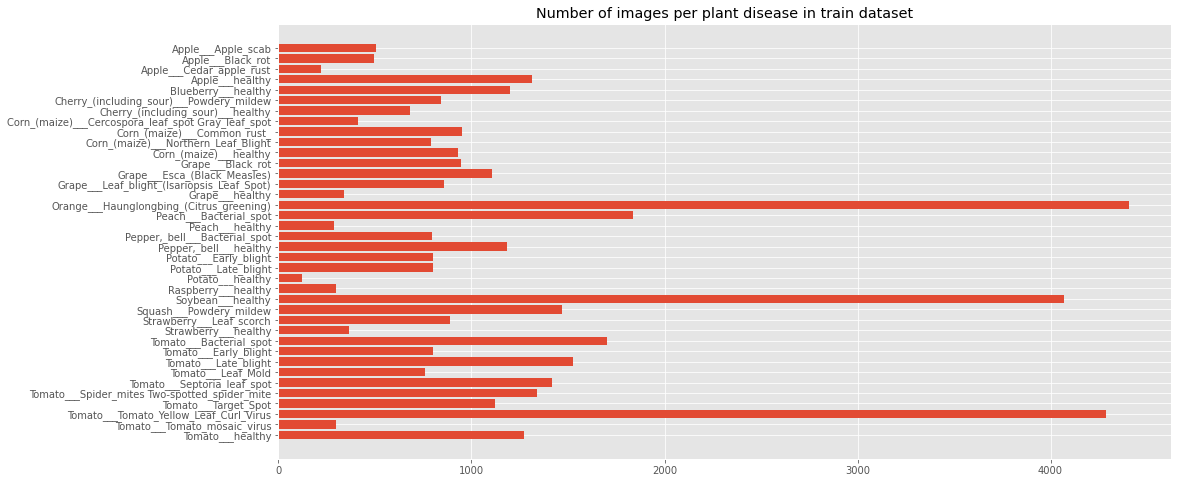

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(16, 8))
plt.title("Number of images per plant disease in train dataset")
plt.barh("Plant_disease", "Number_of_images", data=train_ds_images_per_disease)
plt.gca().invert_yaxis()

In [ ]:
# Data augmentation
train_datagen = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, rescale=1./255,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest", preprocessing_function = preprocess_input)

val_test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function = preprocess_input)

In [ ]:
# get all image paths
image_files = glob.glob('/content/PlantVillage-Dataset-master/raw/color/*/*', 
                   recursive = True)

image_paths_total = []
# loop over the image paths
for imagePath in image_files:
    image_paths_total.append(imagePath)

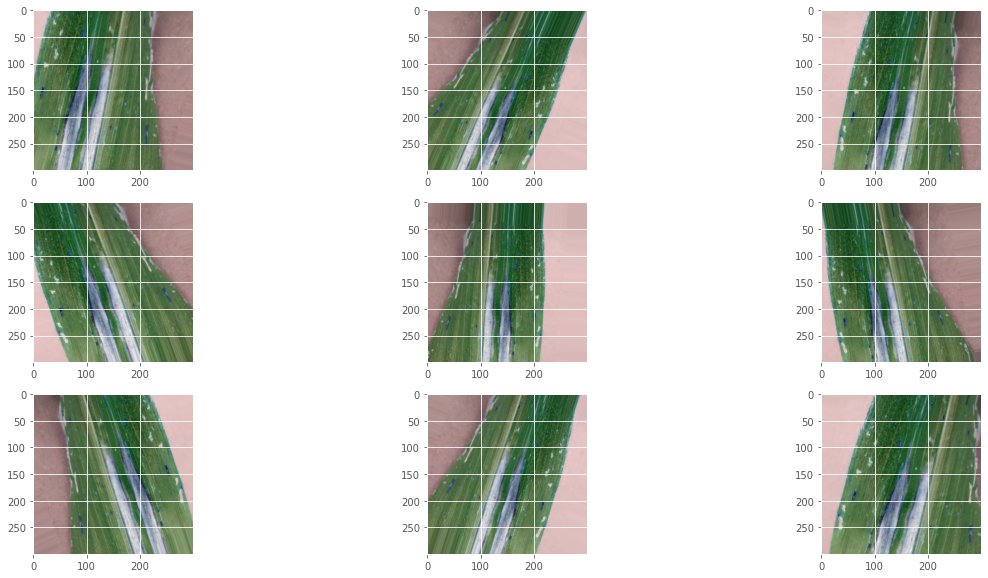

In [ ]:
# Example of augmentation of a sample image
img_path = image_paths_total[1530] 

img = image.load_img(img_path, target_size=(300, 300))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0

fig = plt.figure(figsize=(20, 10))

for batch in train_datagen.flow(x, batch_size=1):
    
    ax = fig.add_subplot(3, 3, i+1)

    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 9 == 0:
        break
        
plt.show()

Here we create the data generators with flow from directory for train/val/test datasets that we will later feed to the model

In [ ]:
# data generators from directories
train_directory = '/content/PlantVillage-Dataset-master/raw/split/train'
train_gen = train_datagen.flow_from_directory(
    train_directory,
    class_mode="categorical",
    color_mode="rgb",
    batch_size=114,
    target_size=(256, 256),
    shuffle=True,
    seed=42,
)

val_directory = '/content/PlantVillage-Dataset-master/raw/split/val'
val_gen = val_test_datagen.flow_from_directory(
    val_directory,
    class_mode="categorical",
    color_mode="rgb",
    batch_size=114,
    target_size=(256, 256),
    shuffle=False,
    seed=42,
)

test_directory = '/content/PlantVillage-Dataset-master/raw/split/test'
test_gen = val_test_datagen.flow_from_directory(
    test_directory,
    class_mode="categorical",
    color_mode="rgb",
    batch_size=53,
    target_size=(256, 256),
    shuffle=False,
    seed=42,
)

Found 43429 images belonging to 38 classes.
Found 5417 images belonging to 38 classes.
Found 5459 images belonging to 38 classes.


Check the images after the preprocess input function

In [ ]:
t_img , label = train_gen.next()

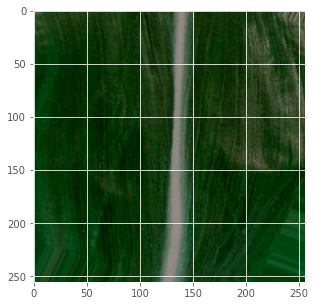

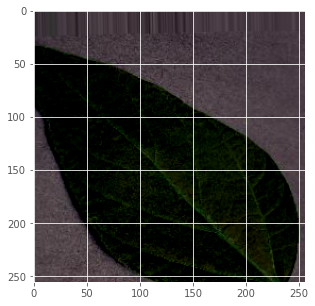

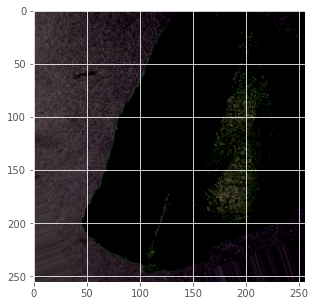

In [ ]:
# plot three images after preprocess function
plotImage(t_img[:3], label[:3])

Here we define our callbacks for the model training

In [ ]:
monitor = 'val_loss'
model_fname = 'best_model.h5'
min_delta = 0

callbacks = [        
    # Stop training when a val_loss has stopped improving.
    EarlyStopping(monitor=monitor,
                  min_delta = min_delta,
                  patience=8,
                  verbose=1,
                  restore_best_weights=True),
    
    # Save the model after every epoch of the monitor quantity improves
    ModelCheckpoint(filepath=model_fname,
                    monitor=monitor,
                    mode = 'min',
                    save_best_only=True,
                    save_weights_only=False,
                    verbose=1),
    
    # Reduce learning rate when a metric has stopped improving
    ReduceLROnPlateau(monitor=monitor,
                      factor=0.1,
                      patience=3,
                      verbose=1)
]

In [ ]:
# training arguments
epochs = 40
learning_rate = 0.0001

# Models build

Our model

In [ ]:
# model built from scratch
model_cnn = Sequential()

model_cnn.add(Conv2D(64,(3,3),activation="relu",padding="same",input_shape=(256,256,3)))
model_cnn.add(Conv2D(64,(3,3),activation="relu",padding="same"))
model_cnn.add(MaxPooling2D(3,3))
model_cnn.add(Dropout(0.1))

model_cnn.add(Conv2D(128,(3,3),activation="relu",padding="same"))
model_cnn.add(Conv2D(128,(3,3),activation="relu",padding="same"))
model_cnn.add(MaxPooling2D(3,3))
model_cnn.add(Dropout(0.25))

model_cnn.add(Conv2D(256,(3,3),activation="relu",padding="same"))
model_cnn.add(Conv2D(256,(3,3),activation="relu",padding="same"))
model_cnn.add(MaxPooling2D(3,3))
model_cnn.add(Dropout(0.25))

model_cnn.add(Flatten())

model_cnn.add(Dense(1024,activation="relu"))
model_cnn.add(Dropout(0.4))

model_cnn.add(Dense(38,activation="softmax"))

opt = keras.optimizers.Adam(learning_rate=learning_rate)
model_cnn.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer=opt, # using the Adam optimiser
              metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ]) 

model_cnn.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 85, 85, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 85, 85, 128)       147584    
                                                        

RESNET 50

In [ ]:
base_model = ResNet50(weights= "imagenet", include_top=False, input_shape= (256,256,3))
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [ ]:
x = base_model.output
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation= 'relu')(x)
predictions = Dense(38, activation= 'softmax')(x)
model_ResNet50 = Model(inputs = base_model.input, outputs = predictions)
opt = keras.optimizers.Adam(learning_rate=learning_rate)
model_ResNet50.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer=opt, # using the Adam optimiser
              metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ]) 
model_ResNet50.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

VGG19

In [ ]:
number_of_classes = 38
#Defining the VGG Convolutional Neural Net
base_model = VGG19(include_top = False, weights = 'imagenet', input_shape = (256,256,3), classes = number_of_classes)
base_model.trainable = False

#Adding the final layers to the above base models where the actual classification is done in the dense layers
model_VGG19 = Sequential()
model_VGG19.add(base_model) 
model_VGG19.add(Flatten()) 

#Adding the Dense layers along with activation and batch normalization
model_VGG19.add(Dense(4096,activation=('relu'),input_dim=512))
model_VGG19.add(Dropout(0.2))
model_VGG19.add(Dense(512,activation=('relu')))
model_VGG19.add(Dropout(0.4))
model_VGG19.add(Dense(38,activation="softmax"))
opt = keras.optimizers.Adam(learning_rate=learning_rate)
model_VGG19.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer=opt, # using the Adam optimiser
              metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ]) 

#Checking the final model summary
model_VGG19.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 4096)              134221824 
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               2097664   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                         

# Model training

In [ ]:
# fit to model
history_model = model_cnn.fit(train_gen,
                    validation_data = val_gen,
                    steps_per_epoch = train_gen.n//train_gen.batch_size,
                    validation_steps = val_gen.n//val_gen.batch_size,
                    callbacks = callbacks,
                    epochs=epochs)

Epoch 1/40
380/380 [==============================] - ETA: 0s - loss: 2.0598 - accuracy: 0.4288 - top-5-accuracy: 0.7286
Epoch 1: val_loss improved from inf to 1.24557, saving model to best_model.h5
380/380 [==============================] - 643s 2s/step - loss: 2.0598 - accuracy: 0.4288 - top-5-accuracy: 0.7286 - val_loss: 1.2456 - val_accuracy: 0.6351 - val_top-5-accuracy: 0.9084 - lr: 1.0000e-04
Epoch 2/40
380/380 [==============================] - ETA: 0s - loss: 1.2454 - accuracy: 0.6316 - top-5-accuracy: 0.8991
Epoch 2: val_loss improved from 1.24557 to 0.94756, saving model to best_model.h5
380/380 [==============================] - 638s 2s/step - loss: 1.2454 - accuracy: 0.6316 - top-5-accuracy: 0.8991 - val_loss: 0.9476 - val_accuracy: 0.7286 - val_top-5-accuracy: 0.9468 - lr: 1.0000e-04
Epoch 3/40
380/380 [==============================] - ETA: 0s - loss: 0.8219 - accuracy: 0.7495 - top-5-accuracy: 0.9576
Epoch 3: val_loss improved from 0.94756 to 0.71679, saving model to bes

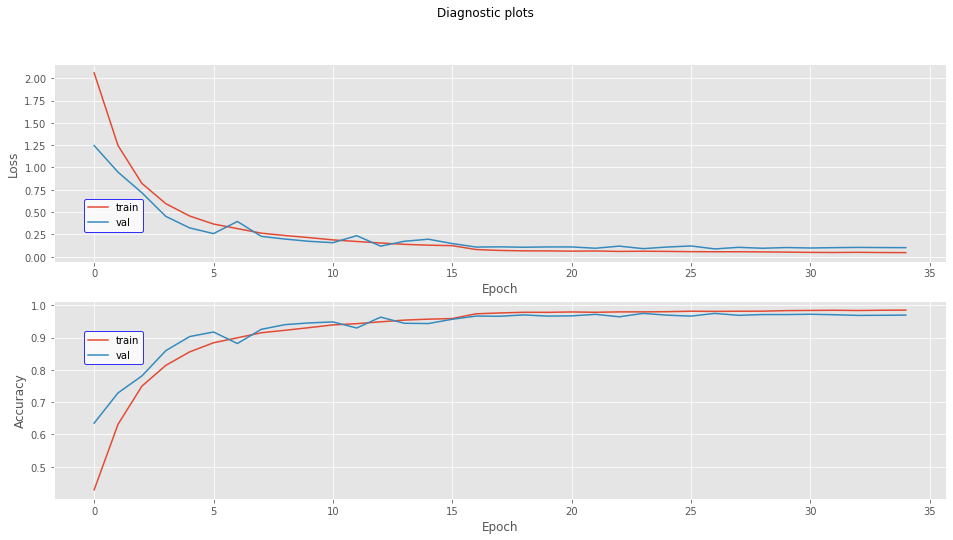

In [ ]:
training_plots(model_cnn,history_model)

In [ ]:
# fit to model
history_ResNet50 = model_ResNet50.fit(train_gen,
                    validation_data = val_gen,
                    # steps_per_epoch = train_gen.n//train_gen.batch_size,
                    # validation_steps = val_gen.n//val_gen.batch_size,
                    callbacks = callbacks,
                    epochs=epochs)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1358/1358 [==============================] - ETA: 0s - loss: 0.9668 - accuracy: 0.7456 - top-5-accuracy: 0.9348
Epoch 1: val_loss improved from inf to 0.39840, saving model to best_model.h5
1358/1358 [==============================] - 40s 20ms/step - loss: 0.9668 - accuracy: 0.7456 - top-5-accuracy: 0.9348 - val_loss: 0.3984 - val_accuracy: 0.8769 - val_top-5-accuracy: 0.9874 - lr: 1.0000e-04
Epoch 2/40
1358/1358 [==============================] - ETA: 0s - loss: 0.4084 - accuracy: 0.8706 - top-5-accuracy: 0.9892
Epoch 2: val_loss improved from 0.39840 to 0.31045, saving model to best_model.h5
1358/1358 [==============================] - 26s 19ms/step - loss: 0.4084 - accuracy: 0.8706 - top-5-accuracy: 0.9892 - val_loss: 0.3105 - val_accuracy: 0.9010 - val_top-5-accuracy: 0.9937 - lr: 1.0000e-04
Epoch 3/40
1355/1358 [============================>.] - ETA: 0s - loss: 0.2994 - accuracy: 0.9009 - top-5-accuracy: 0.9946
Epoch 3: val_loss improved from 0.31045 to 0.29553, saving model to be

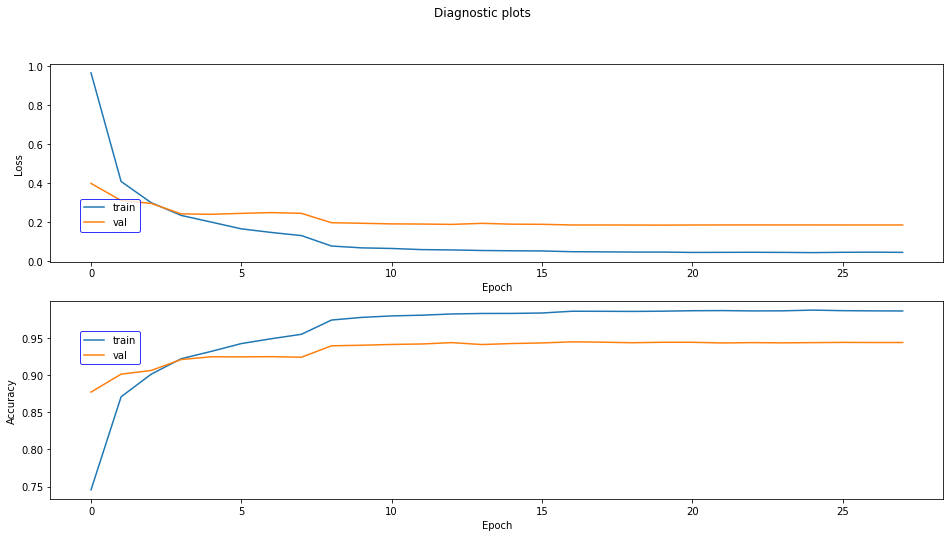

In [ ]:
training_plots(model_ResNet50,history_ResNet50)

In [ ]:
# fit to model
history_VGG19 = model_VGG19.fit(train_gen,
                    validation_data = val_gen,
                    steps_per_epoch = train_gen.n//train_gen.batch_size,
                    validation_steps = val_gen.n//val_gen.batch_size,
                    callbacks = callbacks,
                    epochs=epochs)

Epoch 1/40
380/380 [==============================] - ETA: 0s - loss: 1.3183 - accuracy: 0.6352 - top-5-accuracy: 0.8668
Epoch 1: val_loss improved from inf to 0.39222, saving model to best_model.h5
380/380 [==============================] - 631s 2s/step - loss: 1.3183 - accuracy: 0.6352 - top-5-accuracy: 0.8668 - val_loss: 0.3922 - val_accuracy: 0.8768 - val_top-5-accuracy: 0.9910 - lr: 1.0000e-04
Epoch 2/40
380/380 [==============================] - ETA: 0s - loss: 0.5726 - accuracy: 0.8220 - top-5-accuracy: 0.9761
Epoch 2: val_loss improved from 0.39222 to 0.26014, saving model to best_model.h5
380/380 [==============================] - 615s 2s/step - loss: 0.5726 - accuracy: 0.8220 - top-5-accuracy: 0.9761 - val_loss: 0.2601 - val_accuracy: 0.9188 - val_top-5-accuracy: 0.9966 - lr: 1.0000e-04
Epoch 3/40
380/380 [==============================] - ETA: 0s - loss: 0.4412 - accuracy: 0.8594 - top-5-accuracy: 0.9873
Epoch 3: val_loss improved from 0.26014 to 0.22752, saving model to bes

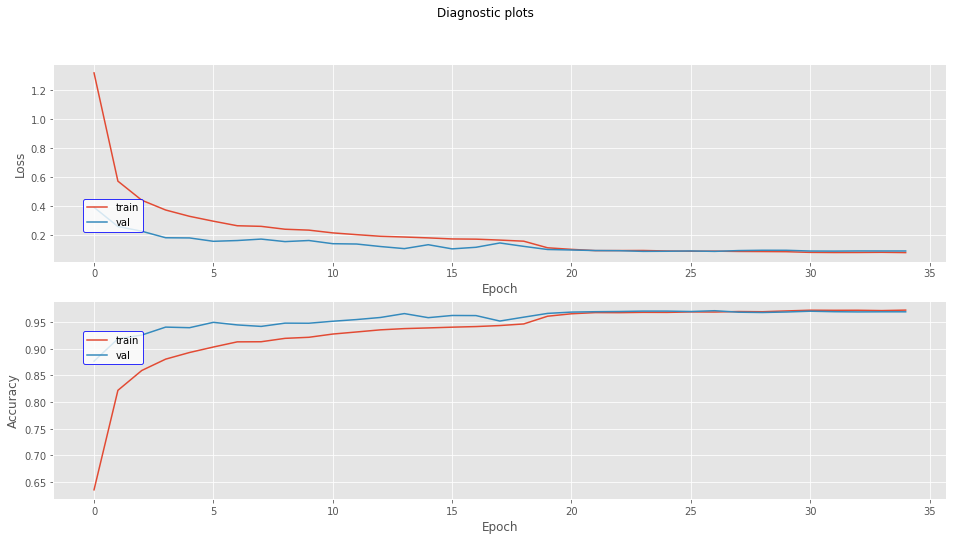

In [ ]:
training_plots(model_VGG19,history_VGG19)

# ViT Model

In the below section we try a different approach using a ViT model built from scratch to train and evaluate our dataset

In [ ]:
# get all image directories in a list

my_list = os.listdir('/content/PlantVillage-Dataset-master/raw/color')
dir_list = [Path.cwd().joinpath('/content/PlantVillage-Dataset-master/raw/color', i)for i in my_list]
dir_list.sort()
my_list.sort()

In [ ]:
# get all image paths
files = glob.glob('/content/PlantVillage-Dataset-master/raw/color/*/*', 
                   recursive = True)

image_paths_total = []
# loop over the image paths
for imagePath in files:
    image_paths_total.append(imagePath)

image_paths_total.sort()

In [ ]:
# all_image_files = [Path.cwd().joinpath('/content/PlantVillage-Dataset-master/raw/color', i)for i in dir_list]
# all_image_files

In [ ]:
# number of images per disease
images_in_dir = [len(os.listdir(dir_list[i])) for i in range(len(dir_list))]
images_per_disease = {'Plant_disease': my_list,
                                'Number_of_images': images_in_dir}
  
images_per_disease = pd.DataFrame(images_per_disease)
images_per_disease

,Plant_disease,Number_of_images
0,Apple___Apple_scab,630
1,Apple___Black_rot,621
2,Apple___Cedar_apple_rust,275
3,Apple___healthy,1645
4,Blueberry___healthy,1502
5,Cherry_(including_sour)___Powdery_mildew,1052
6,Cherry_(including_sour)___healthy,854
7,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,513
8,Corn_(maize)___Common_rust_,1192
9,Corn_(maize)___Northern_Leaf_Blight,985


In [ ]:
# creating the Y targets for each disease path
image_labels = [[i] * (images_in_dir[i]) for i in range(len(images_in_dir))]
image_labels = [x for xs in image_labels for x in xs]

In [ ]:
X_per, y_per = examples_to_dataset(img_paths=image_paths_total,
                           labels=image_labels,
                           block_size=4,
                           as_gray=False)

54305it [05:05, 177.60it/s]


In [ ]:
for i in range(len(X_per)):
  if ((X_per[i].shape[0] != 64) | (X_per[i].shape[1] != 64) | (X_per[i].shape[2] != 3)):
    out_of_shape = i
    print(f'shape of image: {i} is not (64,64,3), but {X_per[out_of_shape].shape} so it will be left out of our dataset')

shape of image: 24008 is not (64,64,3), but (64, 64, 4) so it will be left out of our dataset


In [ ]:
del X_per[out_of_shape]
del y_per[out_of_shape]

In [ ]:
X_per = np.array(X_per)
y_per = np.array(y_per)

In [ ]:
# shuffle all the data

# creating indices from the length of X
indices = np.arange(len(X_per))

# shuffling the indices
np.random.shuffle(indices)

print(f'Getting shuffled indices: {indices}')

# shuffling X and Y
X_per = X_per[indices]
y_per = y_per[indices]

Getting shuffled indices: [18313  8466 11206 ... 40546  1077  5993]


In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_val, y_train, y_val = train_test_split(X_per, y_per, test_size=0.2, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.4, random_state = 42)

[INFO] Spliting data to train, test


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 50
image_size = 72  
patch_size = 6 # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
input_shape = (64, 64, 3)
num_classes = 38

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(Patches, self).__init__()
        self.patch_size = patch_size
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'patch_size': self.patch_size,
        })
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim = projection_dim, **kwargs):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def get_config(self):
        config = super().get_config()
        config.update({
            'num_patches': self.num_patches,
            'projection': self.projection,
            'position_embedding': self.position_embedding,
        })
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.2)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
model = create_vit_classifier()

In [ ]:
optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

In [ ]:
monitor = 'val_loss'
model_fname = 'ViT_model.h5'
min_delta = 0

checkpoint_callback = [
    keras.callbacks.EarlyStopping(
    monitor=monitor,
    min_delta = min_delta,
    patience=8,
    verbose=1,
    restore_best_weights=True),
    
    ReduceLROnPlateau(monitor=monitor,
                      factor=0.1,
                      patience=3,
                      verbose=1),
 
    # Save the model after every epoch of the monitor quantity improves. NOT WORKING. 
    keras.callbacks.ModelCheckpoint(filepath=model_fname,
                   monitor=monitor,
                   mode = 'min',
                   save_best_only=True,
                   save_weights_only=False,
                   verbose=1),
]

In [ ]:
history_2 = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
        callbacks=checkpoint_callback,
)

Epoch 1/50
170/170 [==============================] - ETA: 0s - loss: 1.9045 - accuracy: 0.5009 - top-5-accuracy: 0.7809
Epoch 1: val_loss improved from inf to 0.79748, saving model to ViT_model.h5
170/170 [==============================] - 61s 280ms/step - loss: 1.9045 - accuracy: 0.5009 - top-5-accuracy: 0.7809 - val_loss: 0.7975 - val_accuracy: 0.7618 - val_top-5-accuracy: 0.9610 - lr: 0.0010
Epoch 2/50
170/170 [==============================] - ETA: 0s - loss: 0.9974 - accuracy: 0.7029 - top-5-accuracy: 0.9387
Epoch 2: val_loss improved from 0.79748 to 0.51552, saving model to ViT_model.h5
170/170 [==============================] - 46s 270ms/step - loss: 0.9974 - accuracy: 0.7029 - top-5-accuracy: 0.9387 - val_loss: 0.5155 - val_accuracy: 0.8375 - val_top-5-accuracy: 0.9827 - lr: 0.0010
Epoch 3/50
170/170 [==============================] - ETA: 0s - loss: 0.7060 - accuracy: 0.7846 - top-5-accuracy: 0.9692
Epoch 3: val_loss improved from 0.51552 to 0.35426, saving model to ViT_model

In [ ]:
history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
        callbacks=checkpoint_callback,
)

Epoch 1/50
170/170 [==============================] - ETA: 0s - loss: 1.8802 - accuracy: 0.5017 - top-5-accuracy: 0.7881
Epoch 1: val_loss improved from inf to 0.84891, saving model to ViT_model.h5
170/170 [==============================] - 58s 280ms/step - loss: 1.8802 - accuracy: 0.5017 - top-5-accuracy: 0.7881 - val_loss: 0.8489 - val_accuracy: 0.7494 - val_top-5-accuracy: 0.9524 - lr: 0.0010
Epoch 2/50
170/170 [==============================] - ETA: 0s - loss: 0.9777 - accuracy: 0.7094 - top-5-accuracy: 0.9393
Epoch 2: val_loss improved from 0.84891 to 0.49106, saving model to ViT_model.h5
170/170 [==============================] - 46s 270ms/step - loss: 0.9777 - accuracy: 0.7094 - top-5-accuracy: 0.9393 - val_loss: 0.4911 - val_accuracy: 0.8441 - val_top-5-accuracy: 0.9843 - lr: 0.0010
Epoch 3/50
170/170 [==============================] - ETA: 0s - loss: 0.7070 - accuracy: 0.7879 - top-5-accuracy: 0.9684
Epoch 3: val_loss improved from 0.49106 to 0.37362, saving model to ViT_model

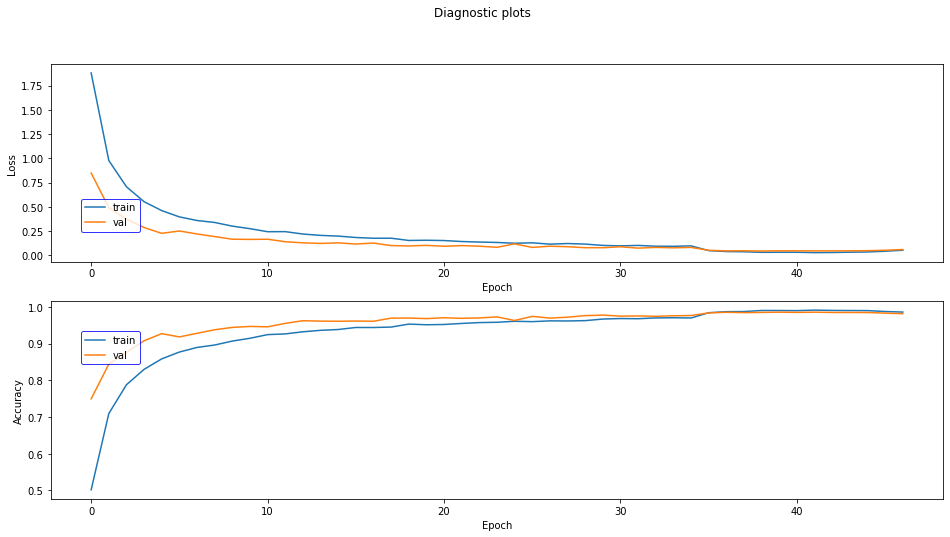

In [ ]:
training_plots(model,history)

# Models evaluation

In [ ]:
# evaluate our model on test dataset
score = model_cnn.evaluate(test_gen,verbose=1)

print(f'Our model Test loss: {score[0]}:')
print('Our model Test accuracy: {:.3f} %'.format(100 * score[1]))

103/103 [==============================] - 20s 156ms/step - loss: 0.0956 - accuracy: 0.9769 - top-5-accuracy: 0.9993
Our model Test loss: 0.09563769400119781:
Our model Test accuracy: 97.692 %


In [ ]:
# evaluate RESNET50 model on test dataset
score = model_ResNet50.evaluate(test_gen,verbose=1)

print(f'RESNET50 Test loss: {score[0]}:')
print('RESNET50 Test accuracy: {:.3f} %'.format(100 * score[1]))

136/136 [==============================] - 2s 17ms/step - loss: 0.2157 - accuracy: 0.9328 - top-5-accuracy: 0.9972
RESNET50 Test loss: 0.21565130352973938:
RESNET50 Test accuracy: 93.280 %


In [ ]:
# evaluate VGG19 model on test dataset
score = model_VGG19.evaluate(test_gen,verbose=1)

print(f'VGG19 Test loss: {score[0]}:')
print('VGG19 Test accuracy: {:.3f} %'.format(100 * score[1]))

103/103 [==============================] - 23s 206ms/step - loss: 0.0889 - accuracy: 0.9707 - top-5-accuracy: 0.9993
VGG19 Test loss: 0.08889338374137878:
VGG19 Test accuracy: 97.069 %


In [ ]:
score = model.evaluate(x_test, y_test,verbose=1)

print(f'Vit Test loss: {score[0]}:')
print('Vit Test accuracy: {:.3f} %'.format(100 * score[1]))

136/136 [==============================] - 3s 21ms/step - loss: 0.0527 - accuracy: 0.9867 - top-5-accuracy: 0.9988
Vit Test loss: 0.05272974818944931:
Vit Test accuracy: 98.665 %


\Make predictions on test dataset with the chosen model (VGG19 model) and create confusion matrix and classification report

**VGG19** **predictions**

In [ ]:
predictions = model_VGG19.predict(test_gen)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

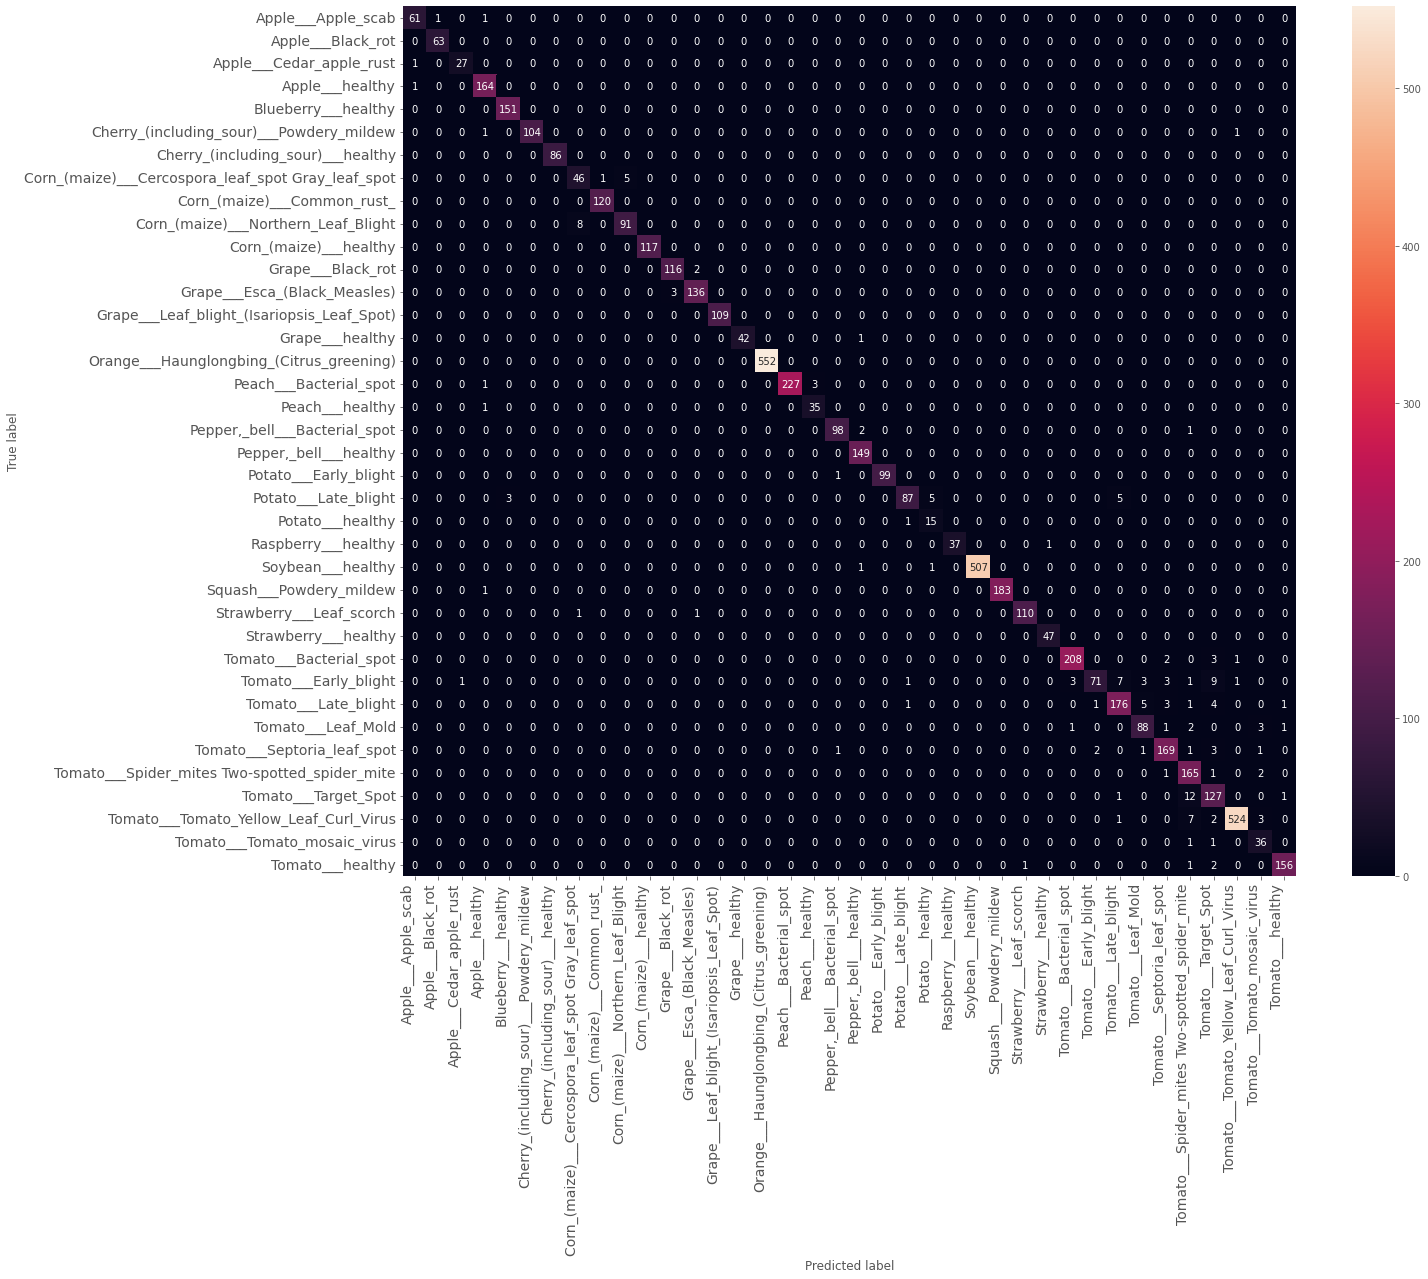

,Apple___Apple_scab,Apple___Black_rot,Apple___Cedar_apple_rust,Apple___healthy,Blueberry___healthy,Cherry_(including_sour)___Powdery_mildew,Cherry_(including_sour)___healthy,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,Corn_(maize)___Common_rust_,Corn_(maize)___Northern_Leaf_Blight,...,Tomato___Bacterial_spot,Tomato___Early_blight,Tomato___Late_blight,Tomato___Leaf_Mold,Tomato___Septoria_leaf_spot,Tomato___Spider_mites Two-spotted_spider_mite,Tomato___Target_Spot,Tomato___Tomato_Yellow_Leaf_Curl_Virus,Tomato___Tomato_mosaic_virus,Tomato___healthy
Apple___Apple_scab,61,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Apple___Black_rot,0,63,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Apple___Cedar_apple_rust,1,0,27,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Apple___healthy,1,0,0,164,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Blueberry___healthy,0,0,0,0,151,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cherry_(including_sour)___Powdery_mildew,0,0,0,1,0,104,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Cherry_(including_sour)___healthy,0,0,0,0,0,0,86,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot,0,0,0,0,0,0,0,46,1,5,...,0,0,0,0,0,0,0,0,0,0
Corn_(maize)___Common_rust_,0,0,0,0,0,0,0,0,120,0,...,0,0,0,0,0,0,0,0,0,0
Corn_(maize)___Northern_Leaf_Blight,0,0,0,0,0,0,0,8,0,91,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
print_confusion_matrix(test_gen.classes, predicted_classes, labels_list)

In [ ]:
print('Classification Report')
print(metrics.classification_report(test_gen.classes, predicted_classes))

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        63
           1       0.98      1.00      0.99        63
           2       0.96      0.96      0.96        28
           3       0.97      0.99      0.98       165
           4       0.98      1.00      0.99       151
           5       1.00      0.98      0.99       106
           6       1.00      1.00      1.00        86
           7       0.84      0.88      0.86        52
           8       0.99      1.00      1.00       120
           9       0.95      0.92      0.93        99
          10       1.00      1.00      1.00       117
          11       0.97      0.98      0.98       118
          12       0.98      0.98      0.98       139
          13       1.00      1.00      1.00       109
          14       1.00      0.98      0.99        43
          15       1.00      1.00      1.00       552
          16       1.00      0.98      0.99       231
     

# Save the best model to use in app

In [ ]:
model_VGG19.save('/content/drive/MyDrive/ML_project/model_VGG19_2.h5')

# Load the best model, upload image and predict

In [47]:
vgg_model = keras.models.load_model('/content/drive/MyDrive/ML_project/model_VGG19_2.h5')

In [34]:
from google.colab import files
images = files.upload()

Saving 005e7424-a343-443e-b165-332cb5bed323___CREC_HLB 7153.JPG to 005e7424-a343-443e-b165-332cb5bed323___CREC_HLB 7153.JPG


In [58]:
img_path = '/content/drive/MyDrive/ML_project/Grape_Esca_(Black_Measles).jpg'

img = tf.keras.utils.load_img(
    img_path, target_size=(256, 256)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = img_array/255.0
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array.shape

TensorShape([1, 256, 256, 3])

In [59]:
predictions = vgg_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels_list[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Grape___Esca_(Black_Measles) with a 6.82 percent confidence.


In [60]:
probabilities = vgg_model.predict(img_array)
print(probabilities)

[[9.11837134e-11 5.46854251e-09 1.20278798e-09 7.76333942e-10
  2.32898645e-10 1.40883180e-10 1.06300406e-10 1.62829106e-09
  1.62000982e-10 7.59579233e-10 8.66695084e-12 3.11859651e-03
  9.96717274e-01 1.52998538e-07 1.77570953e-07 6.74324008e-12
  7.33857286e-09 1.68863482e-11 2.17084262e-09 9.13466913e-10
  2.13305729e-09 9.16356768e-10 2.57120904e-11 2.85834112e-08
  1.36576542e-10 1.95137950e-09 1.03054072e-06 8.25428115e-10
  1.38401501e-09 1.42389414e-04 1.80747156e-05 9.19697596e-10
  1.97954023e-07 1.39073970e-08 1.98013799e-06 1.15191257e-09
  1.01612168e-08 1.31639633e-09]]


In [61]:
indices = np.argsort(-probabilities)
indices

array([[12, 11, 29, 30, 34, 26, 32, 14, 13, 23, 33, 36, 16,  1, 18, 20,
        25,  7, 28, 37,  2, 35, 31, 21, 19, 27,  3,  9,  4,  8,  5, 24,
         6,  0, 22, 17, 10, 15]])